In [1]:
import tarfile
import urllib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [2]:
uci_tcga_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"

# Build the url
full_download_url = urllib.parse.urljoin(uci_tcga_url, archive_name)

# Download the file
r = urllib.request.urlretrieve (full_download_url, archive_name)

# Extract the data from the archive
tar = tarfile.open(archive_name, "r:gz")
tar.extractall()
tar.close()

In [3]:
datafile = "TCGA-PANCAN-HiSeq-801x20531/data.csv"
labels_file = "TCGA-PANCAN-HiSeq-801x20531/labels.csv"

data = np.genfromtxt(
    datafile,
    delimiter=",",
    usecols=range(1, 20532),
    skip_header=1
)

true_label_names = np.genfromtxt(
    labels_file,
    delimiter=",",
    usecols=(1,),
    skip_header=1,
    dtype="str"
)

In [4]:
data[:5, :3]

array([[0.        , 2.01720929, 3.26552691],
       [0.        , 0.59273209, 1.58842082],
       [0.        , 3.51175898, 4.32719872],
       [0.        , 3.66361787, 4.50764878],
       [0.        , 2.65574107, 2.82154696]])

In [5]:
true_label_names[:5]

array(['PRAD', 'LUAD', 'PRAD', 'PRAD', 'BRCA'], dtype='<U4')

I always add 'shape' info to have a better understanding of the data

In [6]:
data.shape, true_label_names.shape

((801, 20531), (801,))

As we can see here, there are too many inputs features, may cause curse of dimensionality

In [7]:
label_encoder = LabelEncoder()

true_labels = label_encoder.fit_transform(true_label_names)

true_labels[:5]

array([4, 3, 4, 4, 0], dtype=int64)

In [8]:
label_encoder.classes_

array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype='<U4')

In [9]:
n_clusters = len(label_encoder.classes_)
n_clusters

5

In [10]:
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

In [11]:
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
   ]
)

The most important takeaway is that The Pipeline class can be chained to form a larger pipeline. Build an end-to-end k-means clustering pipeline by passing the "preprocessor" and "clusterer" pipelines to Pipeline:

In [12]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

In [13]:
pipe.fit(data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=5, n_init=50,
                                         random_state=42))]))])

In [14]:
preprocessed_data = pipe["preprocessor"].transform(data)

In [15]:
predicted_labels = pipe["clusterer"]["kmeans"].labels_

In [16]:
silhouette_score(preprocessed_data, predicted_labels)

0.51187755284503

In [17]:
adjusted_rand_score(true_labels, predicted_labels)

0.722276752060253

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


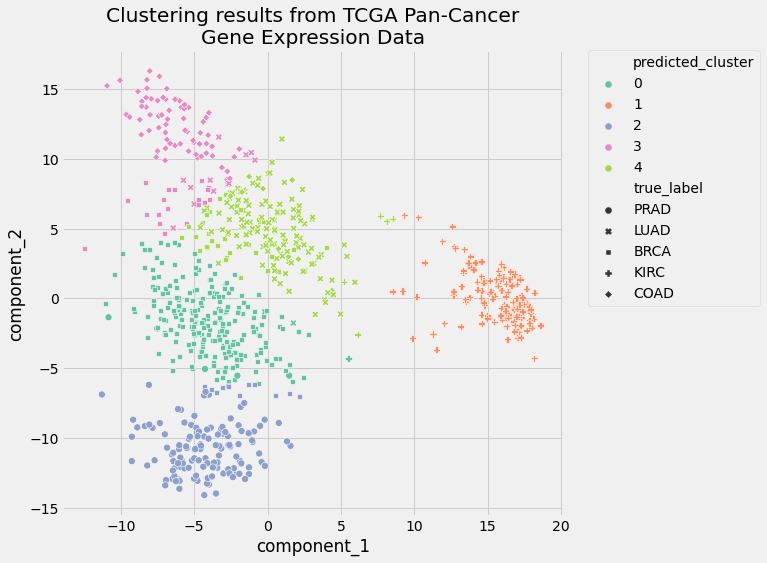

In [18]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(data),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    style="true_label",
    palette="Set2",
)

scat.set_title(
    "Clustering results from TCGA Pan-Cancer\nGene Expression Data"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [19]:
# Empty lists to hold evaluation metrics
silhouette_scores = []
ari_scores = []
for n in range(2, 11):
    # This set the number of components for pca,
    # but leaves other steps unchanged
    pipe["preprocessor"]["pca"].n_components = n
    pipe.fit(data)

    silhouette_coef = silhouette_score(
        pipe["preprocessor"].transform(data),
        pipe["clusterer"]["kmeans"].labels_,
    )
    ari = adjusted_rand_score(
        true_labels,
        pipe["clusterer"]["kmeans"].labels_,
    )

    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)
    ari_scores.append(ari)

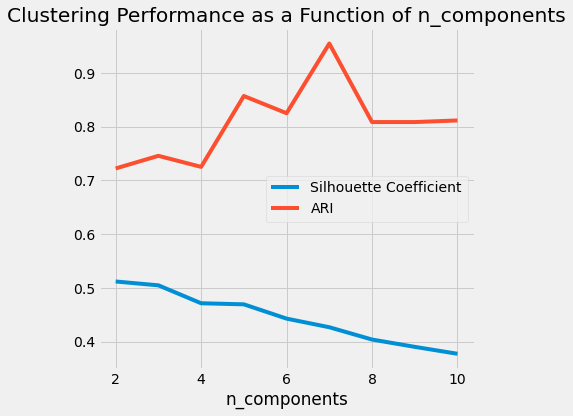

In [20]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(6, 6))
plt.plot(
    range(2, 11),
    silhouette_scores,
    c="#008fd5",
    label="Silhouette Coefficient",
)
plt.plot(range(2, 11), ari_scores, c="#fc4f30", label="ARI")

plt.xlabel("n_components")
plt.legend()
plt.title("Clustering Performance as a Function of n_components")
plt.tight_layout()
plt.show()

There are two takeaways from this figure:

The silhouette coefficient decreases linearly. The silhouette coefficient depends on the distance between points, so as the number of dimensions increases, the sparsity increases.

The ARI improves significantly as you add components. It appears to start tapering off after n_components=7, so that would be the value to use for presenting the best clustering results from this pipeline.